# Guassian mixture models

## Teoria

### O que é?

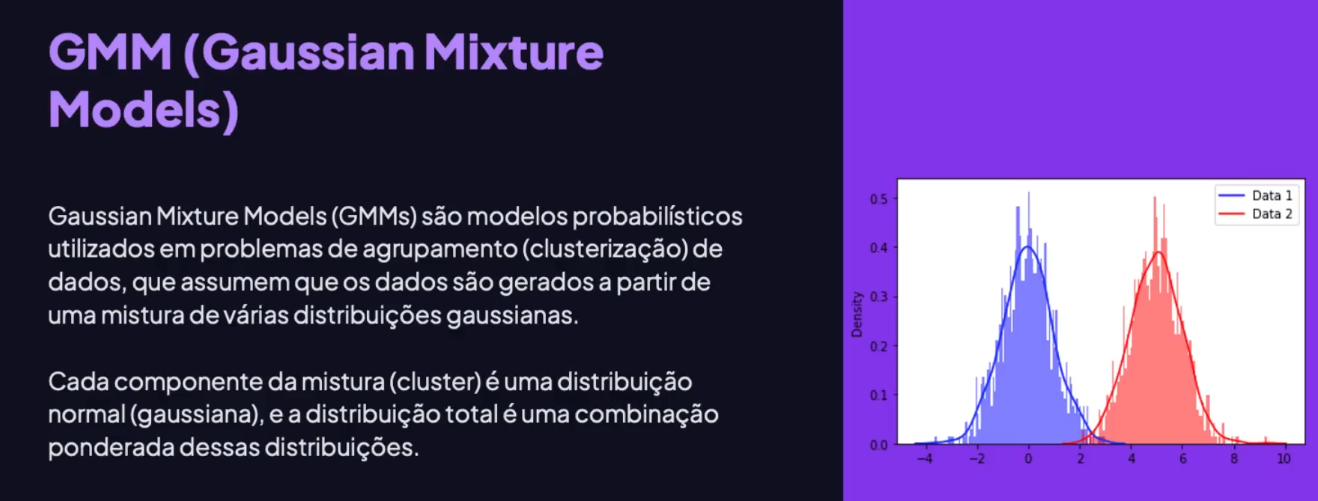

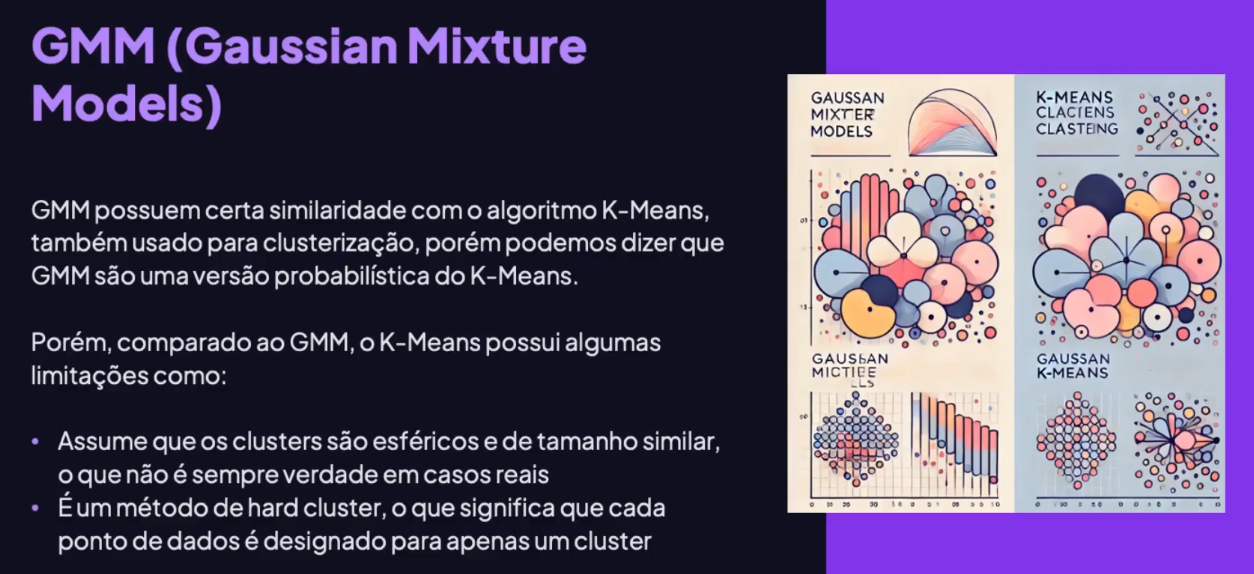

### Casos de uso

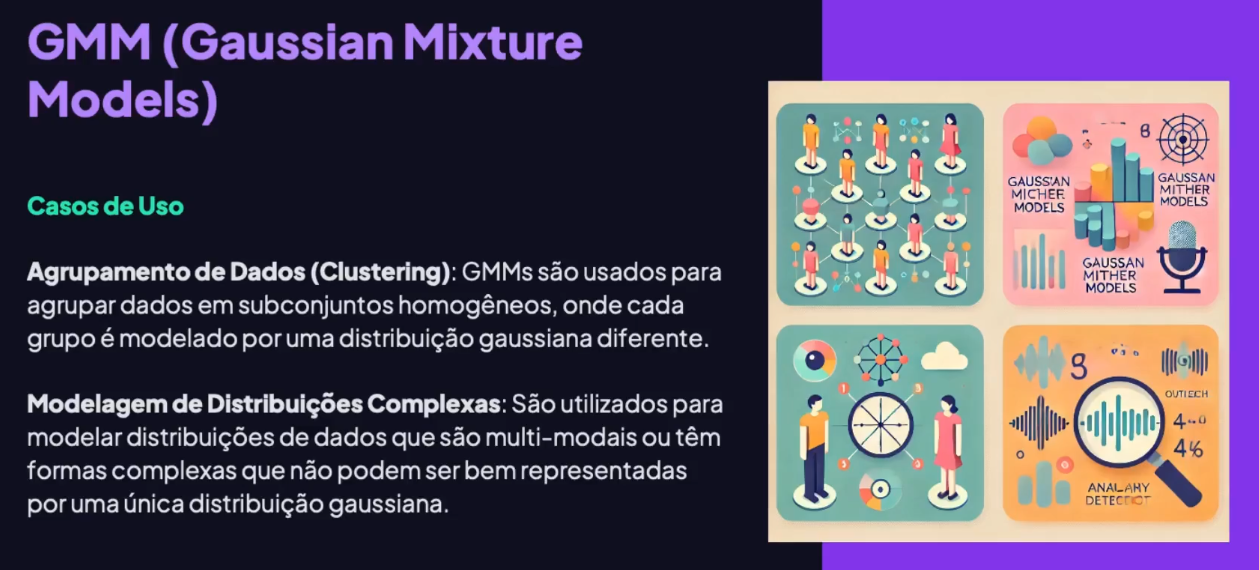

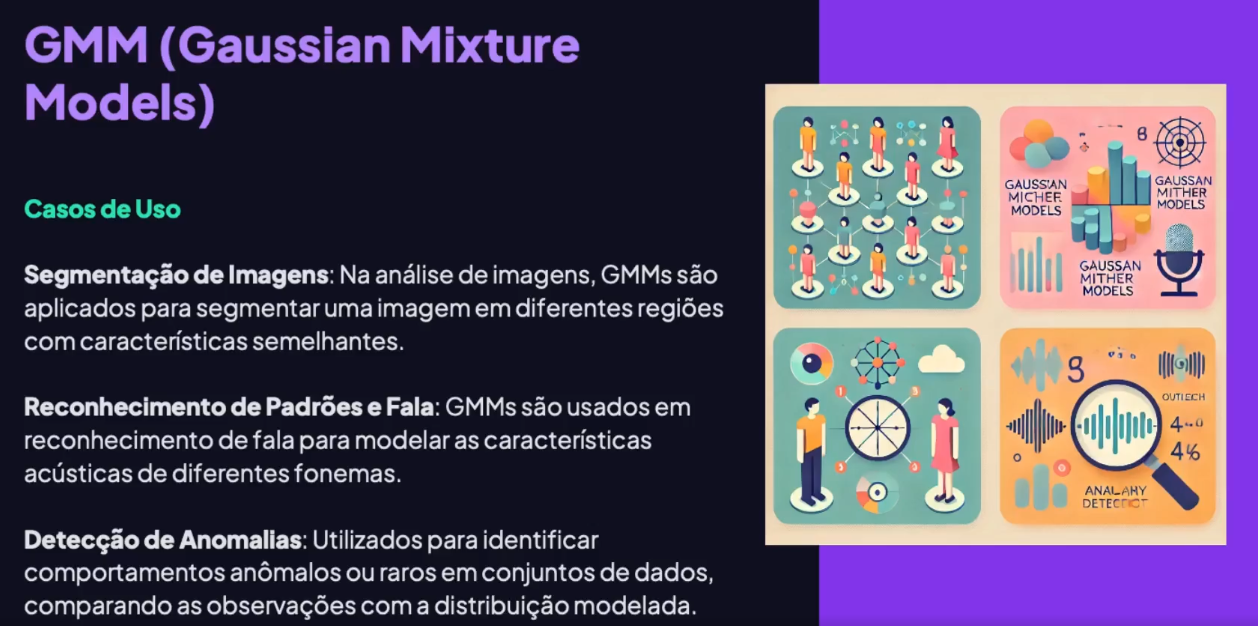

### Vantagens e desvantagens

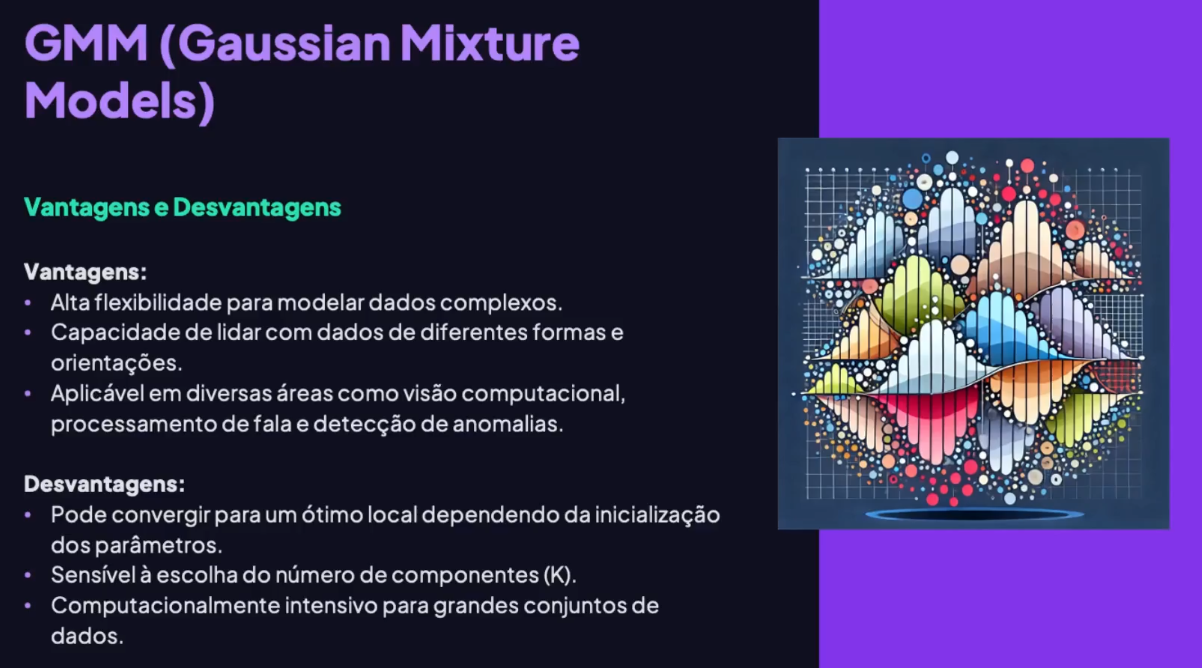

### Como funciona?

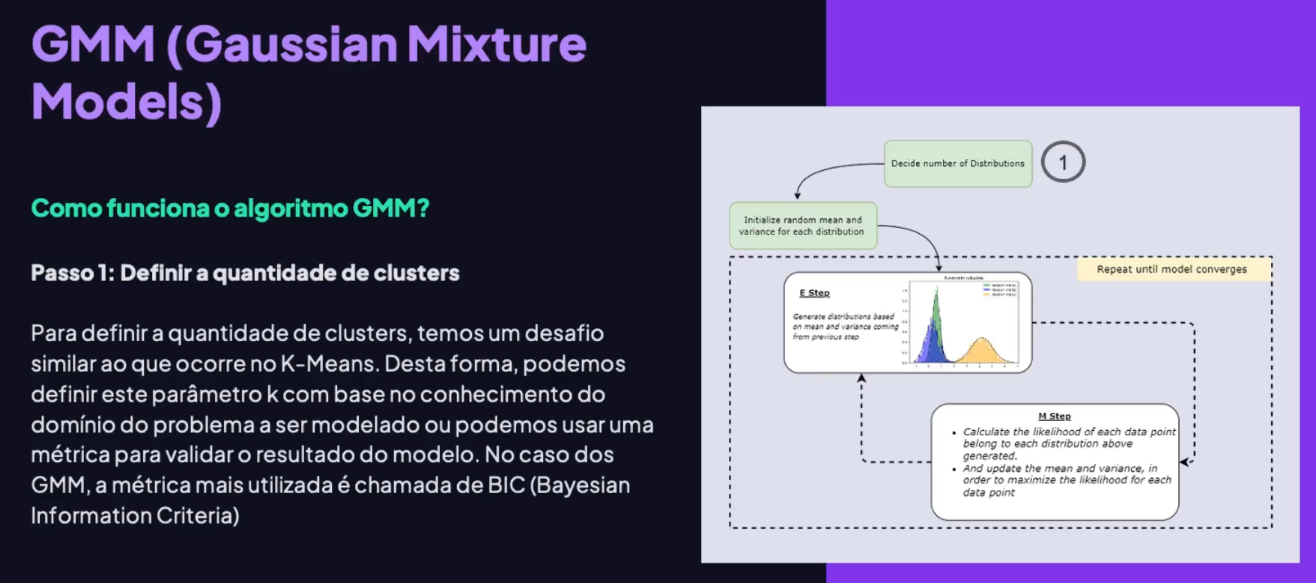

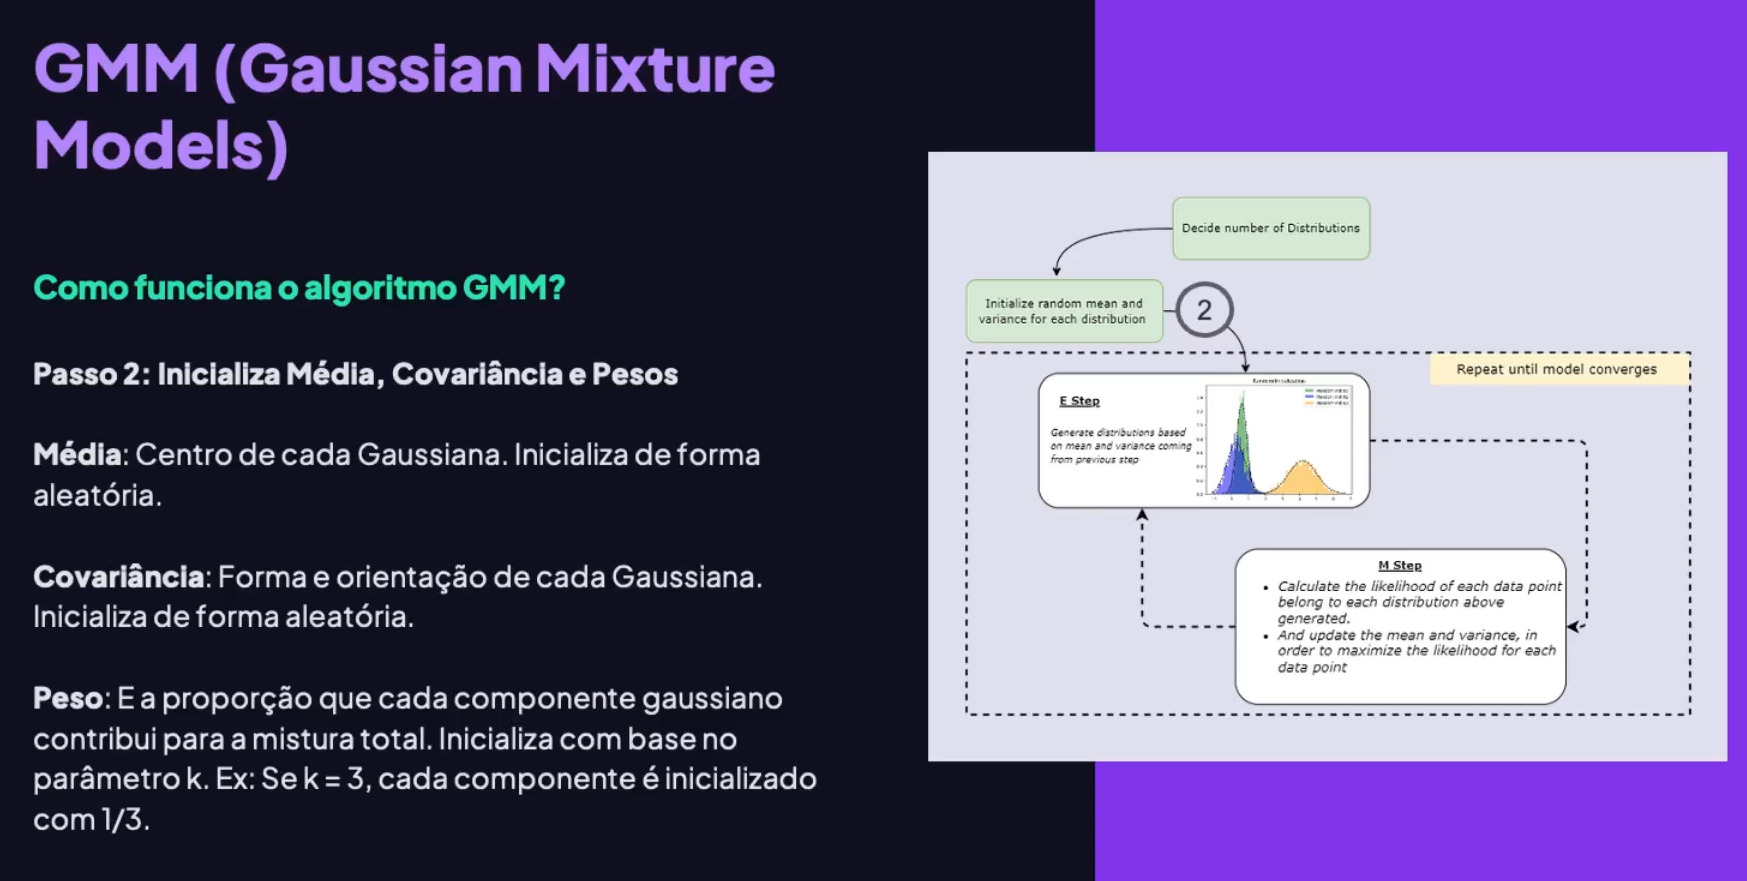

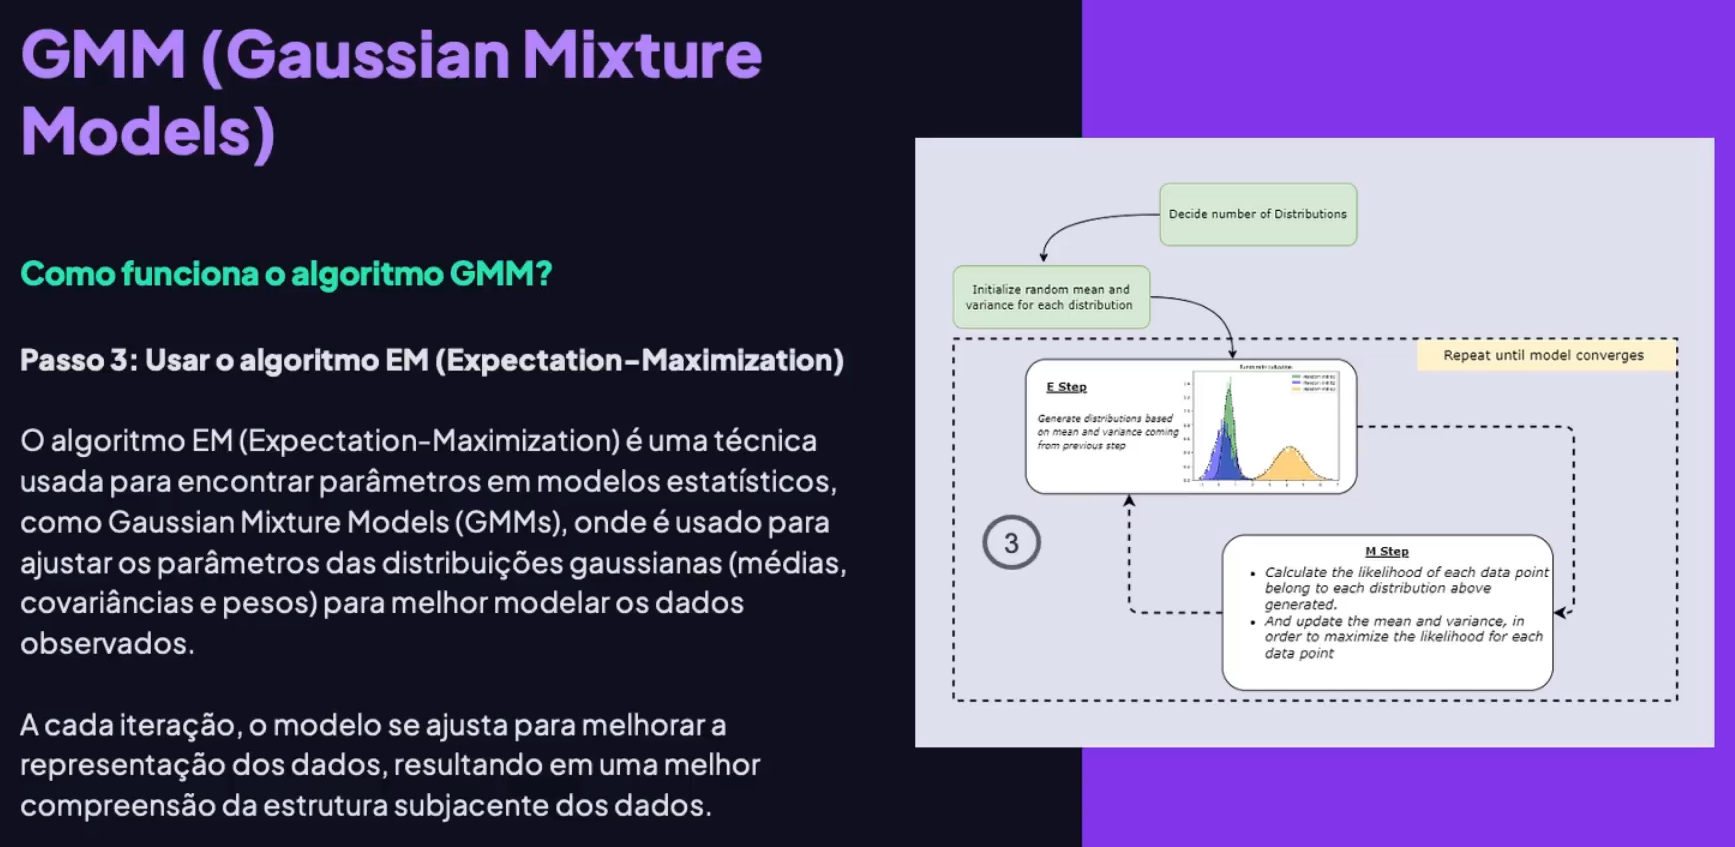

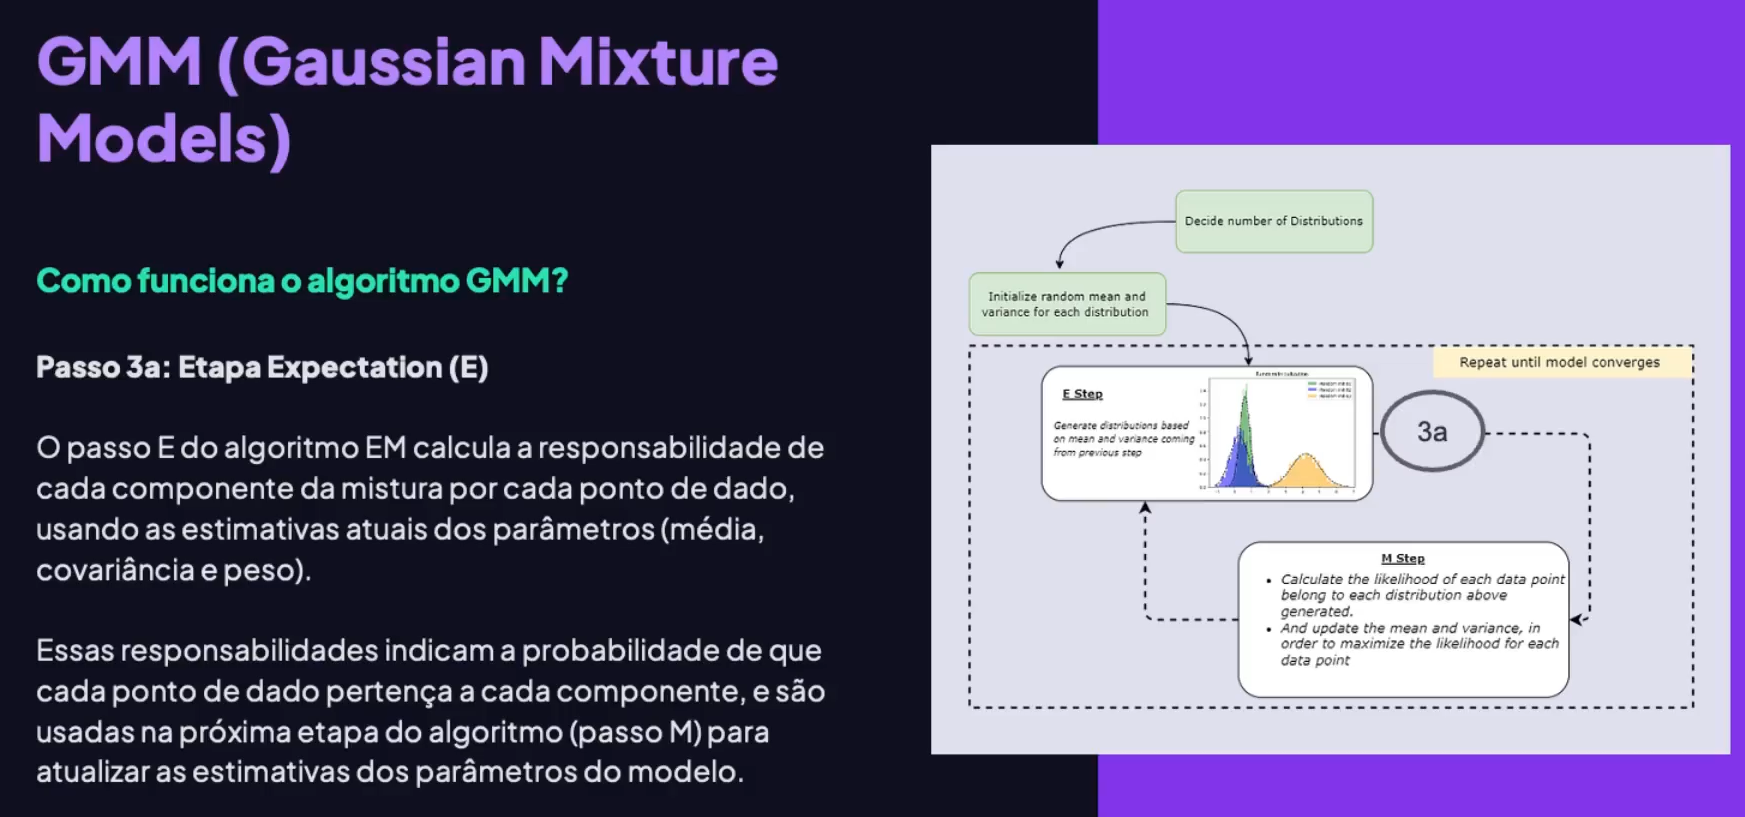

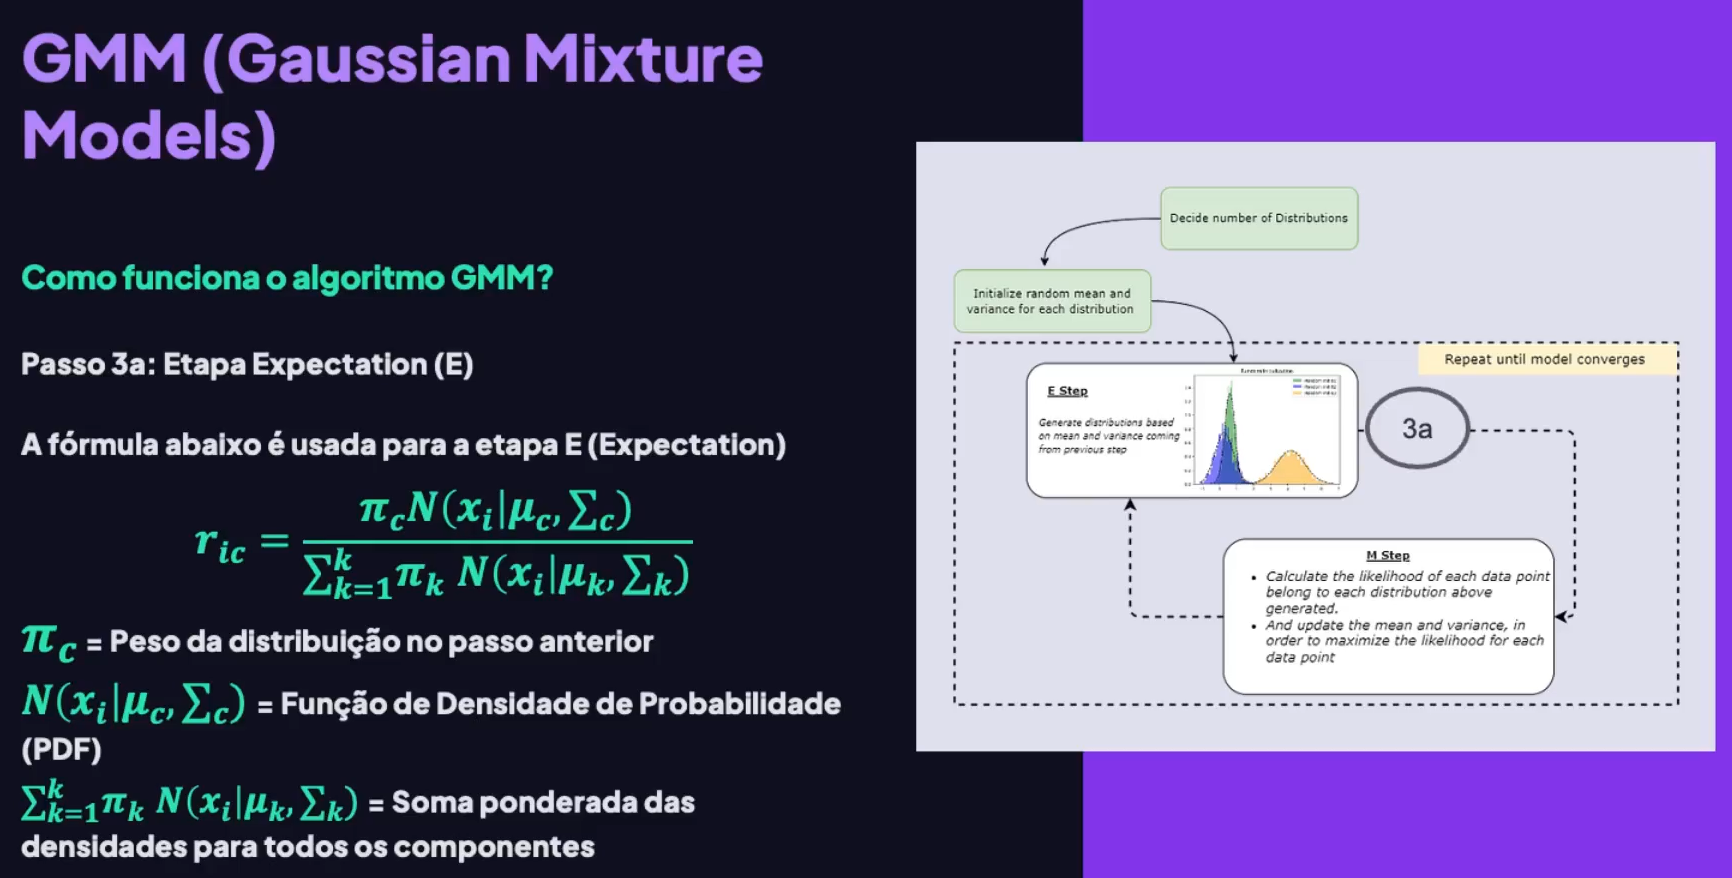

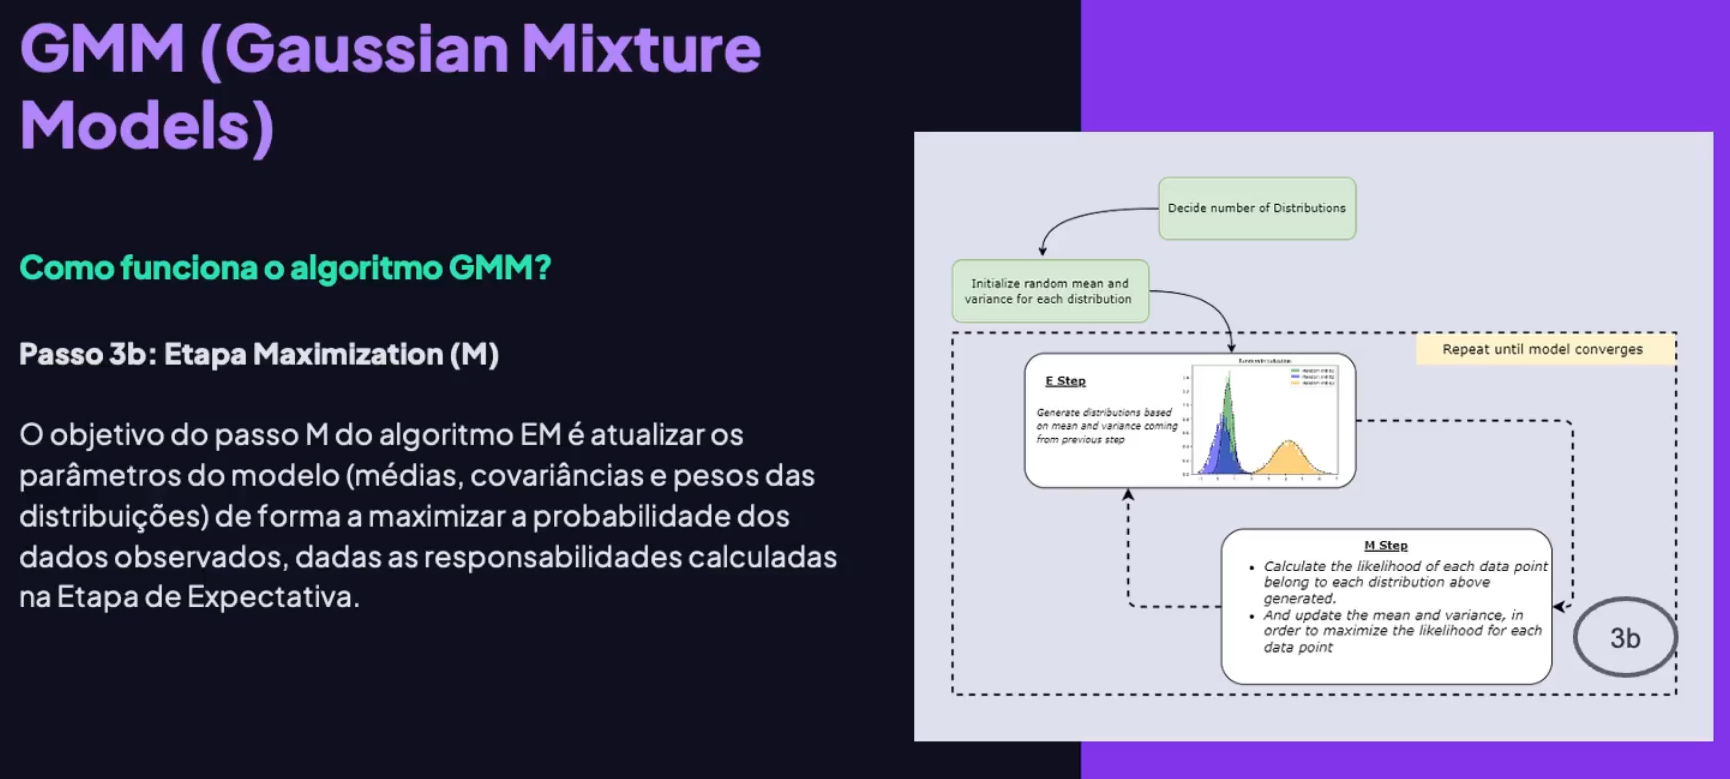

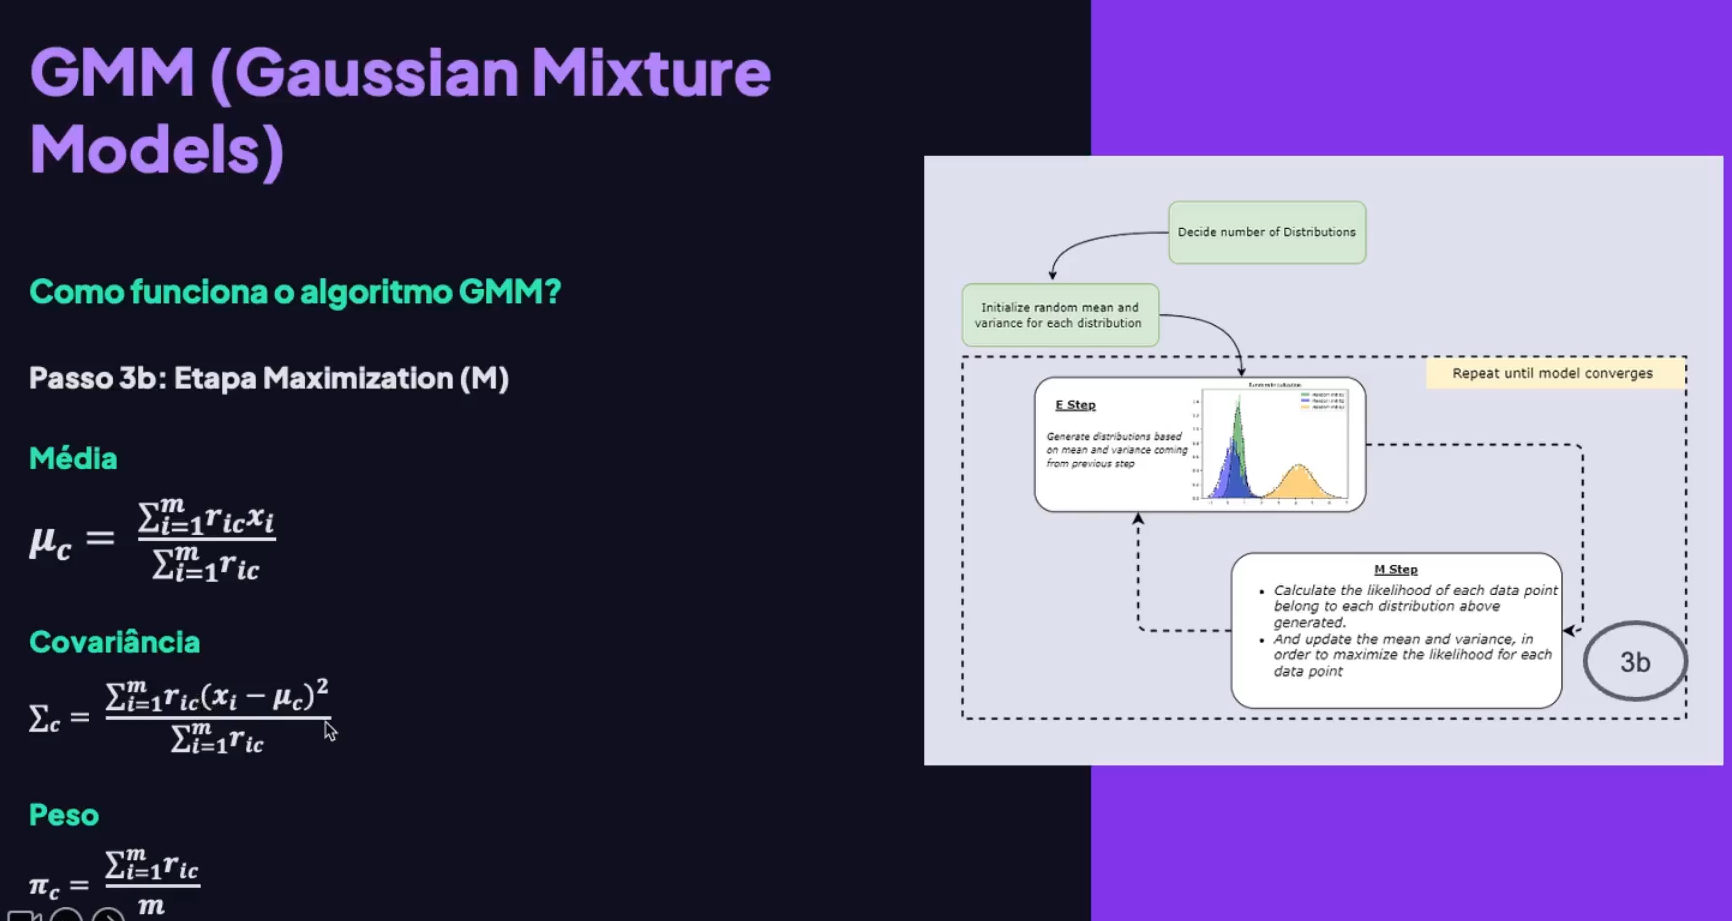

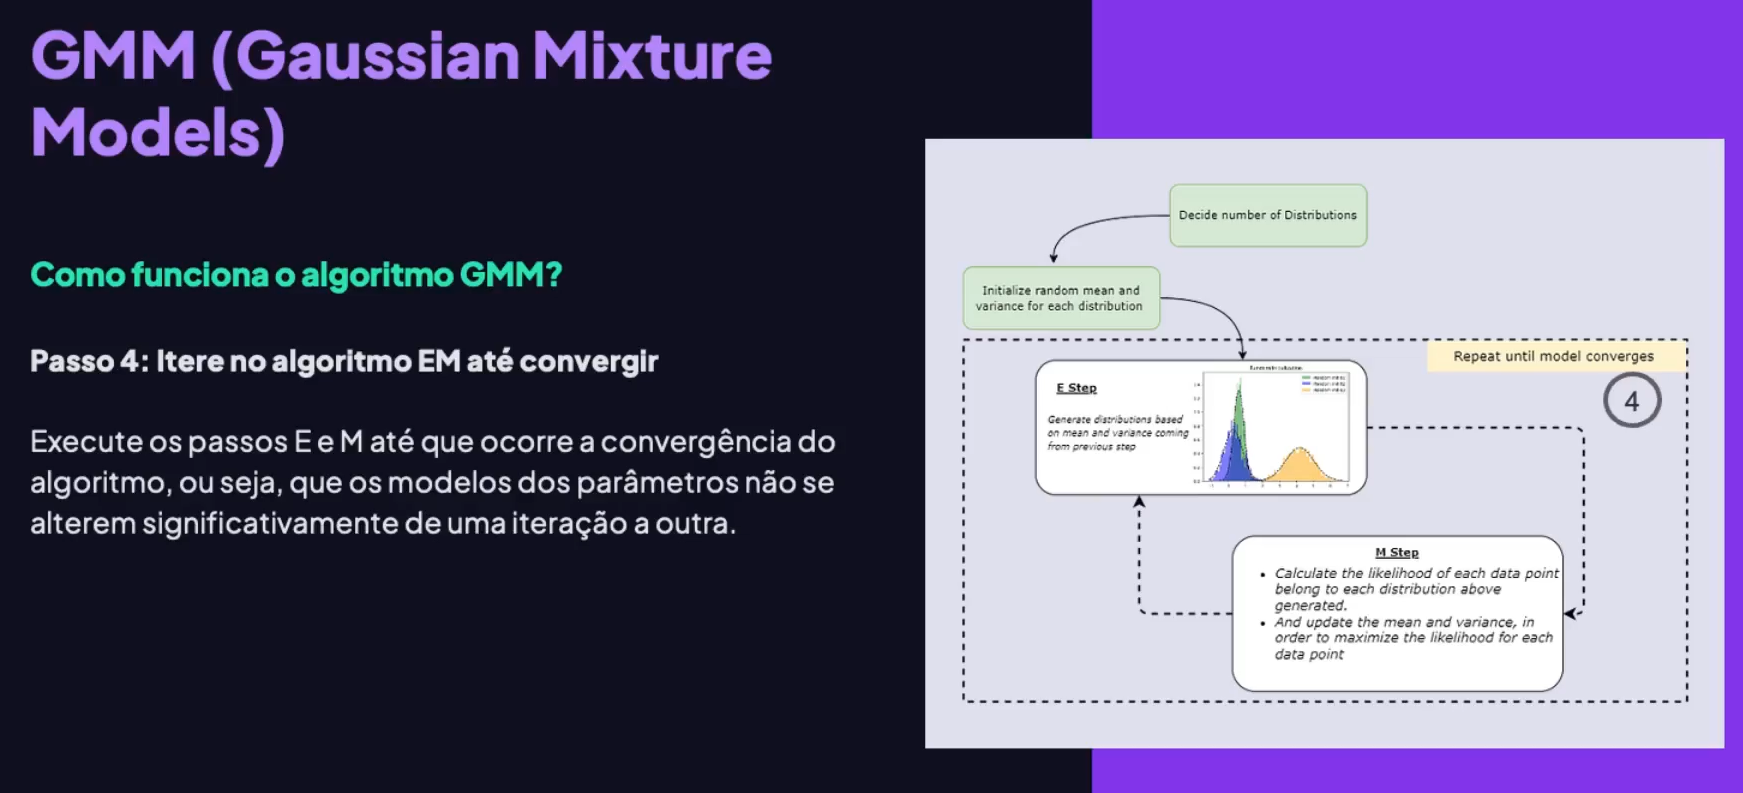

## Importações

`pipenv install pandas plotly scikit-learn optuna ipywidgets ipykernel nbformat gradio -d --python 3.12`

In [2]:
# EDA
import pandas as pd
import numpy as np
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True, precision=10)

# ML
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Otimização
import optuna

## Carga dos dados

In [4]:
# Carga dos dados
df_clients = pd.read_csv('./dataset/clients_dataset.csv')

In [5]:
# Exibir estrutura do dataset
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 23.6+ KB


In [6]:
# Exibir primeiros registros do dataset
df_clients.head(10)

atividade_economica  faturamento_mensal  numero_de_funcionarios  \
0            Comércio           713109.95                      12   
1            Comércio           790714.38                       9   
2            Comércio          1197239.33                      17   
3           Indústria           449185.78                      15   
4         Agronegócio          1006373.16                      15   
5            Serviços          1629562.41                      16   
6            Serviços           771179.95                      13   
7            Serviços           707837.61                      16   
8            Comércio           888983.66                      17   
9           Indústria          1098512.64                      13   

      localizacao  idade  inovacao  
0  Rio de Janeiro      6         1  
1       São Paulo     15         0  
2       São Paulo      4         9  
3       São Paulo      6         0  
4       São Paulo     15         8  
5  Rio de Janeiro     11         4  
6         Vitória      0         1  
7       São Paulo     10         6  
8  Belo Horizonte     10         1  
9  Rio de Janeiro      9         3

In [7]:
# Exibir medidas estatiscas do dataset
df_clients.describe()

faturamento_mensal  numero_de_funcionarios  idade  inovacao
count              500.00                  500.00 500.00    500.00
mean           1026715.63                   13.69   9.25      4.39
std             420609.46                    3.12   2.96      2.90
min              18421.22                    2.00   0.00      0.00
25%             763253.58                   12.00   7.00      2.00
50%            1022957.08                   14.00   9.00      4.00
75%            1295888.52                   16.00  11.00      7.00
max            2390677.22                   21.00  16.00      9.00

## Preparação dos dados para GMM

In [8]:
# Selecionar as colunas relavantes para a clusterização
X = df_clients.copy()

In [9]:
# Separar as variáveis por tipo
numeric_features = ['faturamento_mensal', 'numero_de_funcionarios', 'idade']
categorical_features = ['atividade_economica', 'localizacao']
ordinal_features = ['inovacao']

In [10]:
# Criar os transformes para as variáveis
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()
ordinal_transformer = OrdinalEncoder()

In [11]:
# Criar o pré-processador para tratar as variaveis
preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
		('ord', ordinal_transformer, ordinal_features),
	]
)

In [12]:
# Aplicar o transformador no dataset
X_transformed = preprocessor.fit_transform(X)

In [13]:
# Visualizar o X_transformed
X_transformed

array([[-0.7463449774, -0.5417919104, -1.1005884861, ...,  0.          ,
         0.          ,  1.          ],
       [-0.5616554761, -1.5035526981,  1.9434485069, ...,  1.          ,
         0.          ,  0.          ],
       [ 0.4058265391,  1.0611427358, -1.7770411512, ...,  1.          ,
         0.          ,  9.          ],
       ...,
       [ 2.8196246022, -1.1829657689,  0.2523168441, ...,  0.          ,
         0.          ,  0.          ],
       [ 1.0332141129, -0.5417919104, -1.4388148187, ...,  0.          ,
         0.          ,  3.          ],
       [-2.0301148644, -0.2212049812, -1.7770411512, ...,  0.          ,
         0.          ,  9.          ]])

## Treinar o modelo

In [14]:
def gmm_objective(trial):
  # Definir os hiperparâmetros a serem ajustados
  n_components = trial.suggest_int('n_components', 3, 10)
  covariance_type = trial.suggest_categorical('covariance_type', ['full', 'tied', 'diag', 'spherical'])
  
	# Instanciar o modelo GMM com os hiperparametros
  gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=51)
  
	# Treinar o modelo
  gmm.fit(X_transformed)

	# Calculando o BIC (Bayesian Information Criteria)
  bic_gmm = gmm.bic(X_transformed)
  
  return bic_gmm

In [16]:
# Criar estudo do optuna
search_space = {
  'n_components': range(3, 11),
  'covariance_type': ['full', 'tied', 'diag', 'spherical'],
}
sampler = optuna.samplers.GridSampler(search_space=search_space)

gmm_study = optuna.create_study(direction="maximize", sampler=sampler)

[I 2024-11-10 17:37:08,626] A new study created in memory with name: no-name-efdbc260-f241-4d9d-81da-963c06980913


In [17]:
# Executar o estudo do optuna para otimizar os hierparâmetros
gmm_study.optimize(gmm_objective, n_trials=32)

[I 2024-11-10 17:37:50,411] Trial 0 finished with value: -177.47638667989634 and parameters: {'n_components': 6, 'covariance_type': 'tied'}. Best is trial 0 with value: -177.47638667989634.
[I 2024-11-10 17:37:50,420] Trial 1 finished with value: -23479.731809045454 and parameters: {'n_components': 9, 'covariance_type': 'diag'}. Best is trial 0 with value: -177.47638667989634.
[I 2024-11-10 17:37:50,430] Trial 2 finished with value: -239.1610328338703 and parameters: {'n_components': 5, 'covariance_type': 'tied'}. Best is trial 0 with value: -177.47638667989634.
[I 2024-11-10 17:37:50,461] Trial 3 finished with value: -16669.2276462777 and parameters: {'n_components': 5, 'covariance_type': 'full'}. Best is trial 0 with value: -177.47638667989634.
[I 2024-11-10 17:37:50,464] Trial 4 finished with value: 1570.0096069210786 and parameters: {'n_components': 3, 'covariance_type': 'diag'}. Best is trial 4 with value: 1570.0096069210786.
[I 2024-11-10 17:37:50,495] Trial 5 finished with value

In [18]:
# Melhor configuração obtida pelo optuna
best_params = gmm_study.best_params

In [19]:
# Instanciar e treinar o modelo com os melhores parâmetros
best_gmm_model = GaussianMixture(
  n_components=best_params['n_components'],
  covariance_type=best_params['covariance_type'],
  random_state=51,
)
best_gmm_model.fit(X_transformed)

GaussianMixture(covariance_type='spherical', n_components=3, random_state=51)

In [20]:
# Calcular o BIC do melhor modelo
best_bic = best_gmm_model.bic(X_transformed)

print(f"Quantidade ideal de componentes: {best_params['n_components']}")
print(f"Tipo de covariância: {best_params['covariance_type']}")
print(f"BIC do melhor modelo: {best_bic}")

Quantidade ideal de componentes: 3
Tipo de covariância: spherical
BIC do melhor modelo: 13517.95476525887


## Retornar clusters do melhor modelo GMM

In [24]:
# Executar predict para retornar os clusters
clusters_gmm = best_gmm_model.predict(X_transformed)
clusters_gmm

array([0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 0, 0,
       2, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       0, 1, 2, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2,
       2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0,
       0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0,
       0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0,
       1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0,
       2, 2, 2, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0,
       1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 0, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2,
       0, 0, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1,
       0, 2, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 1, 1,
       1, 1, 2, 0, 0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2,

In [25]:
# Gerar as probabilidades de cada registro estar um cluster
clusters_gmm_prob = best_gmm_model.predict_proba(X_transformed)
clusters_gmm_prob

array([[0.9999798986, 0.          , 0.0000201014],
       [0.9999999957, 0.          , 0.0000000043],
       [0.          , 1.          , 0.          ],
       ...,
       [0.9999999977, 0.          , 0.0000000023],
       [0.053478558 , 0.0000000173, 0.9465214247],
       [0.          , 1.          , 0.          ]])

In [26]:
# Criar coluna cluster no dataframe original
df_clients['cluster'] = clusters_gmm.astype(int)

In [27]:
df_clients.head(10)

atividade_economica  faturamento_mensal  numero_de_funcionarios  \
0            Comércio           713109.95                      12   
1            Comércio           790714.38                       9   
2            Comércio          1197239.33                      17   
3           Indústria           449185.78                      15   
4         Agronegócio          1006373.16                      15   
5            Serviços          1629562.41                      16   
6            Serviços           771179.95                      13   
7            Serviços           707837.61                      16   
8            Comércio           888983.66                      17   
9           Indústria          1098512.64                      13   

      localizacao  idade  inovacao  cluster  
0  Rio de Janeiro      6         1        0  
1       São Paulo     15         0        0  
2       São Paulo      4         9        1  
3       São Paulo      6         0        0  
4       São Paulo     15         8        1  
5  Rio de Janeiro     11         4        2  
6         Vitória      0         1        0  
7       São Paulo     10         6        1  
8  Belo Horizonte     10         1        0  
9  Rio de Janeiro      9         3        2

## Visualizar resultado do GMM

In [28]:
# Cruzar dados de idade, faturamento mensal e clusters
px.scatter(df_clients, x='idade', y='faturamento_mensal', color='cluster')

In [29]:
# Cruzar dados de inovacao, faturamento mensal e clusters
px.scatter(df_clients, x='inovacao', y='faturamento_mensal', color='cluster')

In [30]:
# Cruzar dados de inovacao, idade e clusters
px.scatter(df_clients, x='inovacao', y='idade', color='cluster')

## Salvar o modelo

In [31]:
import joblib

# Salvar o modelo
joblib.dump(best_gmm_model, 'clustering_model_gmm_clients.pkl')

# Salvar o pipeline
joblib.dump(preprocessor, 'clustering_pipeline_gmm_clients.pkl')

['clustering_pipeline_gmm_clients.pkl']

## Aplicação

In [32]:
import gradio as gr

model = joblib.load('./clustering_model_gmm_clients.pkl')
pipeline = joblib.load('./clustering_pipeline_gmm_clients.pkl')

In [33]:
def clustering(file):
  df_companies = pd.read_csv(file.name)
  
	# Transformar os dados do dataframe
  X_transformed = pipeline.fit_transform(df_companies)
  
  model.fit(X_transformed)
  
  clusters_companies = model.predict(X_transformed)
  
  df_companies['cluster'] = clusters_companies.astype(int)
  
  df_companies.to_csv('./clusters_companies.csv', index=False)
  
  return './clusters_companies.csv'

In [34]:
app = gr.Interface(
  clustering,
  gr.File(file_types=['.csv']),
  "file",
)

app.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
